# **Course:** Introduction to Computer Vision (CS231.Q11)

**Topic:** Face Mask Classification

**Member:** 
- Nguyen Cong Phat - 23521143
- Nguyen Le Phong - 23521168
- Vu Viet Cuong - 23520213 

In [1]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## **1. Imports & config**

In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import seaborn as sns
from tqdm import tqdm
import joblib

In [3]:
DATA_DIR = Path("D:/UIT/HK1_25-26/CS231.Q11NhapMonCV/DoAn/Face Mask Dataset")  

SPLITS = ["Train", "Validation", "Test"]
CLASSES = ["WithMask", "WithoutMask"]

IMAGE_SIZE = (128, 128)

# HOG 8x2
HOG_PARAMS = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys"
}

CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

MODELS_DIR = Path("D:/UIT/HK1_25-26/CS231.Q11NhapMonCV/DoAn/CS231Project/models")  # lưu model chung ở ngoài
MODELS_DIR.mkdir(exist_ok=True, parents=True)

## **2. Load image paths & basic stats**

In [4]:
def load_split_paths(split: str):
    """
    Trả về list đường dẫn ảnh và nhãn tương ứng
    cho split: Train / Validation / Test
    """
    paths = []
    labels = []
    split_dir = DATA_DIR / split
    for cls in CLASSES:
        class_dir = split_dir / cls
        for img_path in sorted(class_dir.glob("*.*")):
            paths.append(img_path)
            labels.append(cls)
    return np.array(paths), np.array(labels)

all_stats = {}

for split in SPLITS:
    paths, labels = load_split_paths(split)
    unique, counts = np.unique(labels, return_counts=True)
    stats = dict(zip(unique, counts))
    all_stats[split] = stats

all_stats

{'Train': {'WithMask': 5000, 'WithoutMask': 5000},
 'Validation': {'WithMask': 400, 'WithoutMask': 400},
 'Test': {'WithMask': 483, 'WithoutMask': 509}}

## **3. Plot class distribution**

C:\Users\NguyenCongPhat\AppData\Local\Temp\ipykernel_25568\4110489579.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(stats.keys(), rotation=15)
C:\Users\NguyenCongPhat\AppData\Local\Temp\ipykernel_25568\4110489579.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(stats.keys(), rotation=15)
C:\Users\NguyenCongPhat\AppData\Local\Temp\ipykernel_25568\4110489579.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(stats.keys(), rotation=15)


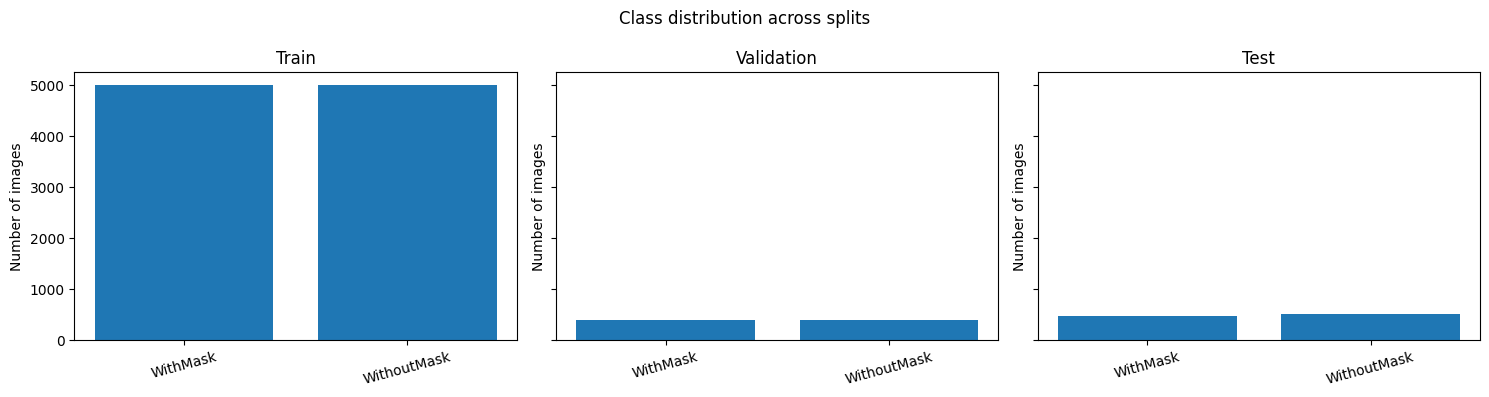

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i, split in enumerate(SPLITS):
    stats = all_stats[split]
    ax = axes[i]
    ax.bar(stats.keys(), stats.values())
    ax.set_title(split)
    ax.set_ylabel("Number of images")
    ax.set_xticklabels(stats.keys(), rotation=15)

plt.suptitle("Class distribution across splits")
plt.tight_layout()
plt.show()

## **4. Show some sample images**

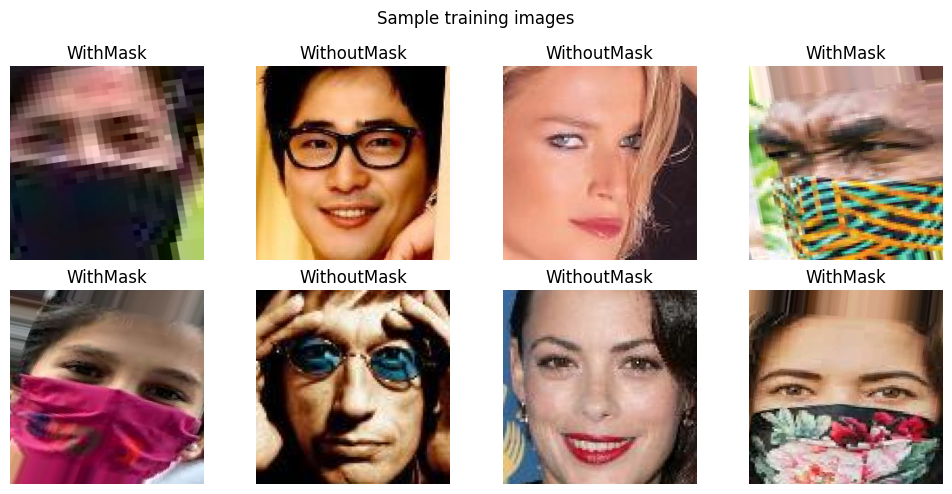

In [6]:
paths_train, labels_train = load_split_paths("Train")

plt.figure(figsize=(10, 5))
idxs = np.random.choice(len(paths_train), size=8, replace=False)
for i, idx in enumerate(idxs, 1):
    img = imread(paths_train[idx])
    plt.subplot(2, 4, i)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.title(labels_train[idx])
plt.suptitle("Sample training images")
plt.tight_layout()
plt.show()

## **5. HOG feature extractor + visualize HOG for 1 image**

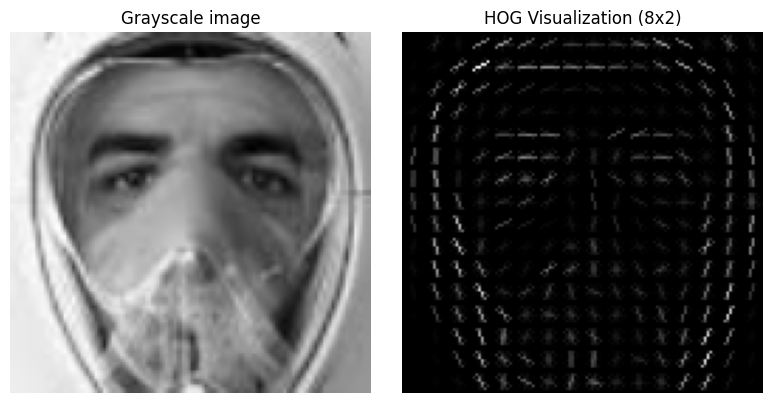

HOG feature length: 8100


In [13]:
def extract_hog_feature(img_path: Path, hog_params: dict) -> np.ndarray:
    img = imread(img_path)
    if img.ndim == 3:
        img_gray = rgb2gray(img)
    else:
        img_gray = img

    img_resized = resize(img_gray, IMAGE_SIZE, anti_aliasing=True)
    feat = hog(img_resized, **hog_params)
    return feat


# visualize HOG
from skimage.feature import hog as hog_vis

sample_img_path = paths_train[0]
sample_img = imread(sample_img_path)
sample_gray = rgb2gray(sample_img) if sample_img.ndim == 3 else sample_img
sample_resized = resize(sample_gray, IMAGE_SIZE, anti_aliasing=True)

hog_feats, hog_image = hog_vis(sample_resized, visualize=True, **HOG_PARAMS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_resized, cmap="gray")
plt.title("Grayscale image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Visualization (8x2)")
plt.axis("off")

plt.tight_layout()
plt.show()

print("HOG feature length:", hog_feats.size)

## **6. Build & cache HOG features**

In [8]:
def get_hog_features(split: str):
    cache_file = CACHE_DIR / f"HOG_8x2_{split}.npz"

    if cache_file.exists():
        data = np.load(cache_file)
        print(f"[{split}] Loaded from cache")
        return data["X"], data["y"]

    print(f"[{split}] Extracting HOG features...")
    paths, labels = load_split_paths(split)

    feats = []
    for p in tqdm(paths):
        feats.append(extract_hog_feature(p, HOG_PARAMS))

    X = np.vstack(feats)
    y = labels
    np.savez_compressed(cache_file, X=X, y=y)
    print(f"[{split}] Saved to cache")
    return X, y


X_train, y_train = get_hog_features("Train")
X_val,   y_val   = get_hog_features("Validation")
X_test,  y_test  = get_hog_features("Test")

X_train.shape, X_val.shape, X_test.shape

[Train] Extracting HOG features...


100%|██████████| 10000/10000 [05:49<00:00, 28.63it/s]


[Train] Saved to cache
[Validation] Extracting HOG features...


100%|██████████| 800/800 [01:04<00:00, 12.48it/s]


[Validation] Saved to cache
[Test] Extracting HOG features...


100%|██████████| 992/992 [01:10<00:00, 14.04it/s]


[Test] Saved to cache


((10000, 8100), (800, 8100), (992, 8100))

## **7. Encode labels**

In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

le.classes_, np.bincount(y_train_enc)

(array(['WithMask', 'WithoutMask'], dtype='<U11'),
 array([5000, 5000], dtype=int64))

## **8. Optuna + KNN (HOG 8x2)**

In [10]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from sklearn.neighbors import KNeighborsClassifier

def objective(trial):
    # Không gian tham số cho KNN
    params = {
        # số láng giềng, thử số lẻ 1–31 để tránh tie
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 31, step=2),
        # uniform: mọi hàng xóm như nhau, distance: hàng xóm gần hơn trọng số lớn hơn
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        # p = 1: Manhattan, p = 2: Euclidean
        "p": trial.suggest_int("p", 1, 2),
        # metric để mặc định minkowski (dùng chung với p)
        "metric": "minkowski",
    }

    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train_enc)

    y_val_pred = clf.predict(X_val)
    acc = accuracy_score(y_val_enc, y_val_pred)
    return acc


study_knn = optuna.create_study(
    direction="maximize",
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1),
    sampler=TPESampler(multivariate=True),
)

study_knn.optimize(objective, n_trials=30, n_jobs=1)  

print("[HOG-KNN-8x2] Best validation accuracy:", study_knn.best_value)
print("[HOG-KNN-8x2] Best params:", study_knn.best_params)

c:\Users\NguyenCongPhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-29 22:00:11,725] A new study created in memory with name: no-name-15801266-5b8f-4895-93fd-d9a41e9f19a5
[I 2025-11-29 22:00:19,746] Trial 0 finished with value: 0.93375 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.93375.
[I 2025-11-29 22:00:44,652] Trial 1 finished with value: 0.96375 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.96375.
[I 2025-11-29 22:00:54,856] Trial 2 finished with value: 0.96 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.96375.
[I 2025-11-29 22:00:55,488] Trial 3 finished with value: 0.92625 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}. Best i

[HOG-KNN-8x2] Best validation accuracy: 0.9875
[HOG-KNN-8x2] Best params: {'n_neighbors': 1, 'weights': 'distance', 'p': 1}


## **9. Refit best KNN on Train + Validation**

In [11]:
best_knn_params = study_knn.best_params.copy()

X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train_enc, y_val_enc])

best_knn = KNeighborsClassifier(**best_knn_params)
best_knn.fit(X_combined, y_combined)

print("Done training final HOG-KNN-8x2 with Optuna best params.")
best_knn_params

Done training final HOG-KNN-8x2 with Optuna best params.


{'n_neighbors': 1, 'weights': 'distance', 'p': 1}

## **10. Evaluate on Test + confusion matrix + save KNN model**

Test Accuracy (HOG 8x2 + KNN Optuna): 0.9839

Classification report (KNN):
              precision    recall  f1-score   support

    WithMask       1.00      0.97      0.98       483
 WithoutMask       0.97      1.00      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



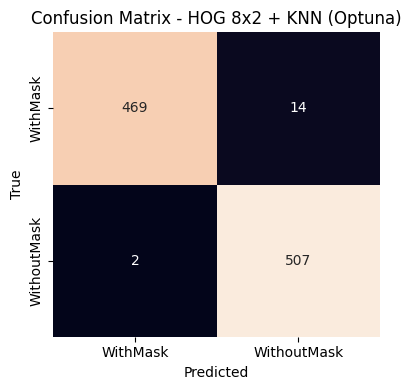

HOG-KNN-8x2 model saved to: D:\UIT\HK1_25-26\CS231.Q11NhapMonCV\DoAn\CS231Project\models\HOG_8x2_KNN_Optuna.joblib


In [12]:
y_test_pred_knn = best_knn.predict(X_test)

test_acc_knn = accuracy_score(y_test_enc, y_test_pred_knn)
print(f"Test Accuracy (HOG 8x2 + KNN Optuna): {test_acc_knn:.4f}\n")

print("Classification report (KNN):")
print(classification_report(y_test_enc, y_test_pred_knn, target_names=le.classes_))

cm_knn = confusion_matrix(y_test_enc, y_test_pred_knn)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar=False
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HOG 8x2 + KNN (Optuna)")
plt.tight_layout()
plt.show()

# Lưu model + encoder + HOG params
model_path_knn = MODELS_DIR / "HOG_8x2_KNN_Optuna.joblib"

joblib.dump(
    {
        "model": best_knn,
        "label_encoder": le,
        "hog_params": HOG_PARAMS,
        "image_size": IMAGE_SIZE,
    },
    model_path_knn
)

print("HOG-KNN-8x2 model saved to:", model_path_knn)